# Class 20: Confidence intervals

Plan for today:
- Hypothesis tests for correlation
- Visual hypothesis tests
- Two-sided hypothesis tests
- Confidence intervals


In [47]:
import YData

# YData.download.download_class_code(20)   # get class code    
# YData.download.download_class_code(20, TRUE) # get the code with the answers 

# YData.download.download_class_file('project_template.ipynb', 'homework')  # downloads the class project template 
# YData.download_homework(8)  # downloads the 8th homework 

YData.download_data("amazon.csv")

The file `amazon.csv` already exists.
If you would like to download a new copy of the file, please rename the existing copy of the file.


If you are using colabs, you should run the code below.

In [48]:
# !pip install https://github.com/emeyers/YData_package/tarball/master
# from google.colab import drive
# drive.mount('/content/drive')

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


## 1. Hypothesis tests for correlation

Let's run a hypothesis tests for correlation to see if books that have more pages cost more! 


### Step 1: State the null and alternative hypotheses

**In words** 

Null hypthesis: There is no correlation between the number of pages in a book and the cost of the book. 

Alternative hypothesis: Books that have more pages cost more. 

**In symbols**

$H_0$: $\rho = 0$  

$H_A$: $\rho > 0$  


### Step 2: Calculate the observed statistic

Data on 230 books from Amazon.com are loaded below. Let's calculate the observed correlation ($r$) between the number of pages in the book (`NumPages`) and the listed price (`List.Price`). 

To make your life easier, first just reduce the data set to only the `NumPages` and `List.Price` columns and save this to a DataFrame called `amazon_smaller`. Then use `amazon_smaller` for the rest of this problem


In [50]:
amazon = pd.read_csv("amazon.csv")

amazon.head(3)

,Title,Author,List.Price,Amazon.Price,Hard..Paper,NumPages,Publisher,Pub.year,ISBN.10,Height,Width,Thick,Weight..oz.
0,"1,001 Facts that Will Scare the S#*t Out of Yo...",Cary McNeal,12.95,5.18,P,304,Adams Media,2010.0,1605506249,7.8,5.5,0.8,11.2
1,21: Bringing Down the House - Movie Tie-In: Th...,Ben Mezrich,15.00,10.20,P,273,Free Press,2008.0,1416564195,8.4,5.5,0.7,7.2
2,100 Best-Loved Poems (Dover Thrift Editions),Smith,1.50,1.50,P,96,Dover Publications,1995.0,486285537,8.3,5.2,0.3,4.0


In [51]:
import statistics

amazon_smaller = amazon[["NumPages", "List.Price"]]

obs_stat = statistics.correlation(amazon_smaller.NumPages, amazon_smaller["List.Price"])

obs_stat

0.21455197256312525

### Step 3: Create the null distribution 

How can we create one statistic consistent with the null hypothesis? 

See if you can create one statistic consistent with the null distribution below. Once you have done that, create the full null distribution!



In [52]:
# Create one statistic consistent with the null distribution
statistics.correlation(amazon_smaller.NumPages, np.random.permutation(amazon_smaller["List.Price"]))


0.009476526455688432

In [53]:
%%time

# Create the full null distribution

null_dist = []

for i in range(10000):  
        
    shuff_stat = statistics.correlation(amazon_smaller.NumPages, 
                                        np.random.permutation(amazon_smaller["List.Price"]))
    
    null_dist.append(shuff_stat)



CPU times: user 2.73 s, sys: 39.1 ms, total: 2.76 s
Wall time: 3.04 s


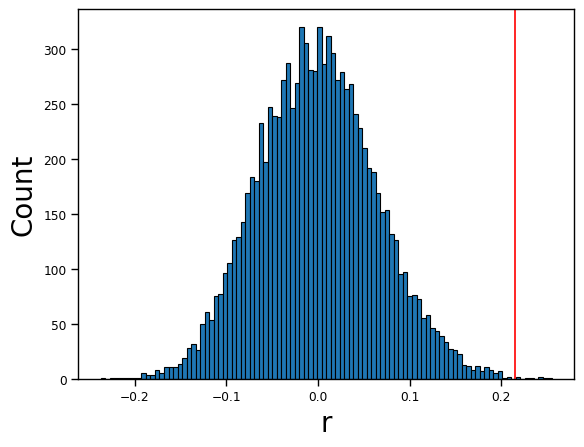

In [54]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 100);


# put a line at the observed statistic value

plt.axvline(obs_stat, color = "red");
plt.xlabel("r");
plt.ylabel("Count");

### Step 4: Calculate the p-value


In [55]:
p_value = np.mean(np.array(null_dist) >= obs_stat)

p_value

0.0008

### Step 5: Draw a conclusion

The p-value is small (less than the convensional level of 0.05) so we would reject the null hypothesis and conclude that there is a correlation between the number of pages in a book and the price of a book at the population level. 


## 2. Visualizing hypothesis tests for correlation

We can also run a visual hypothesis test for correlation by creating a visual lineup that displays several scatter plots of shuffled data and one scatter plot of the real data. If you can tell which plot contains the real (unshuffled) data, this corresponds to being able to reject the null hypothesis. 


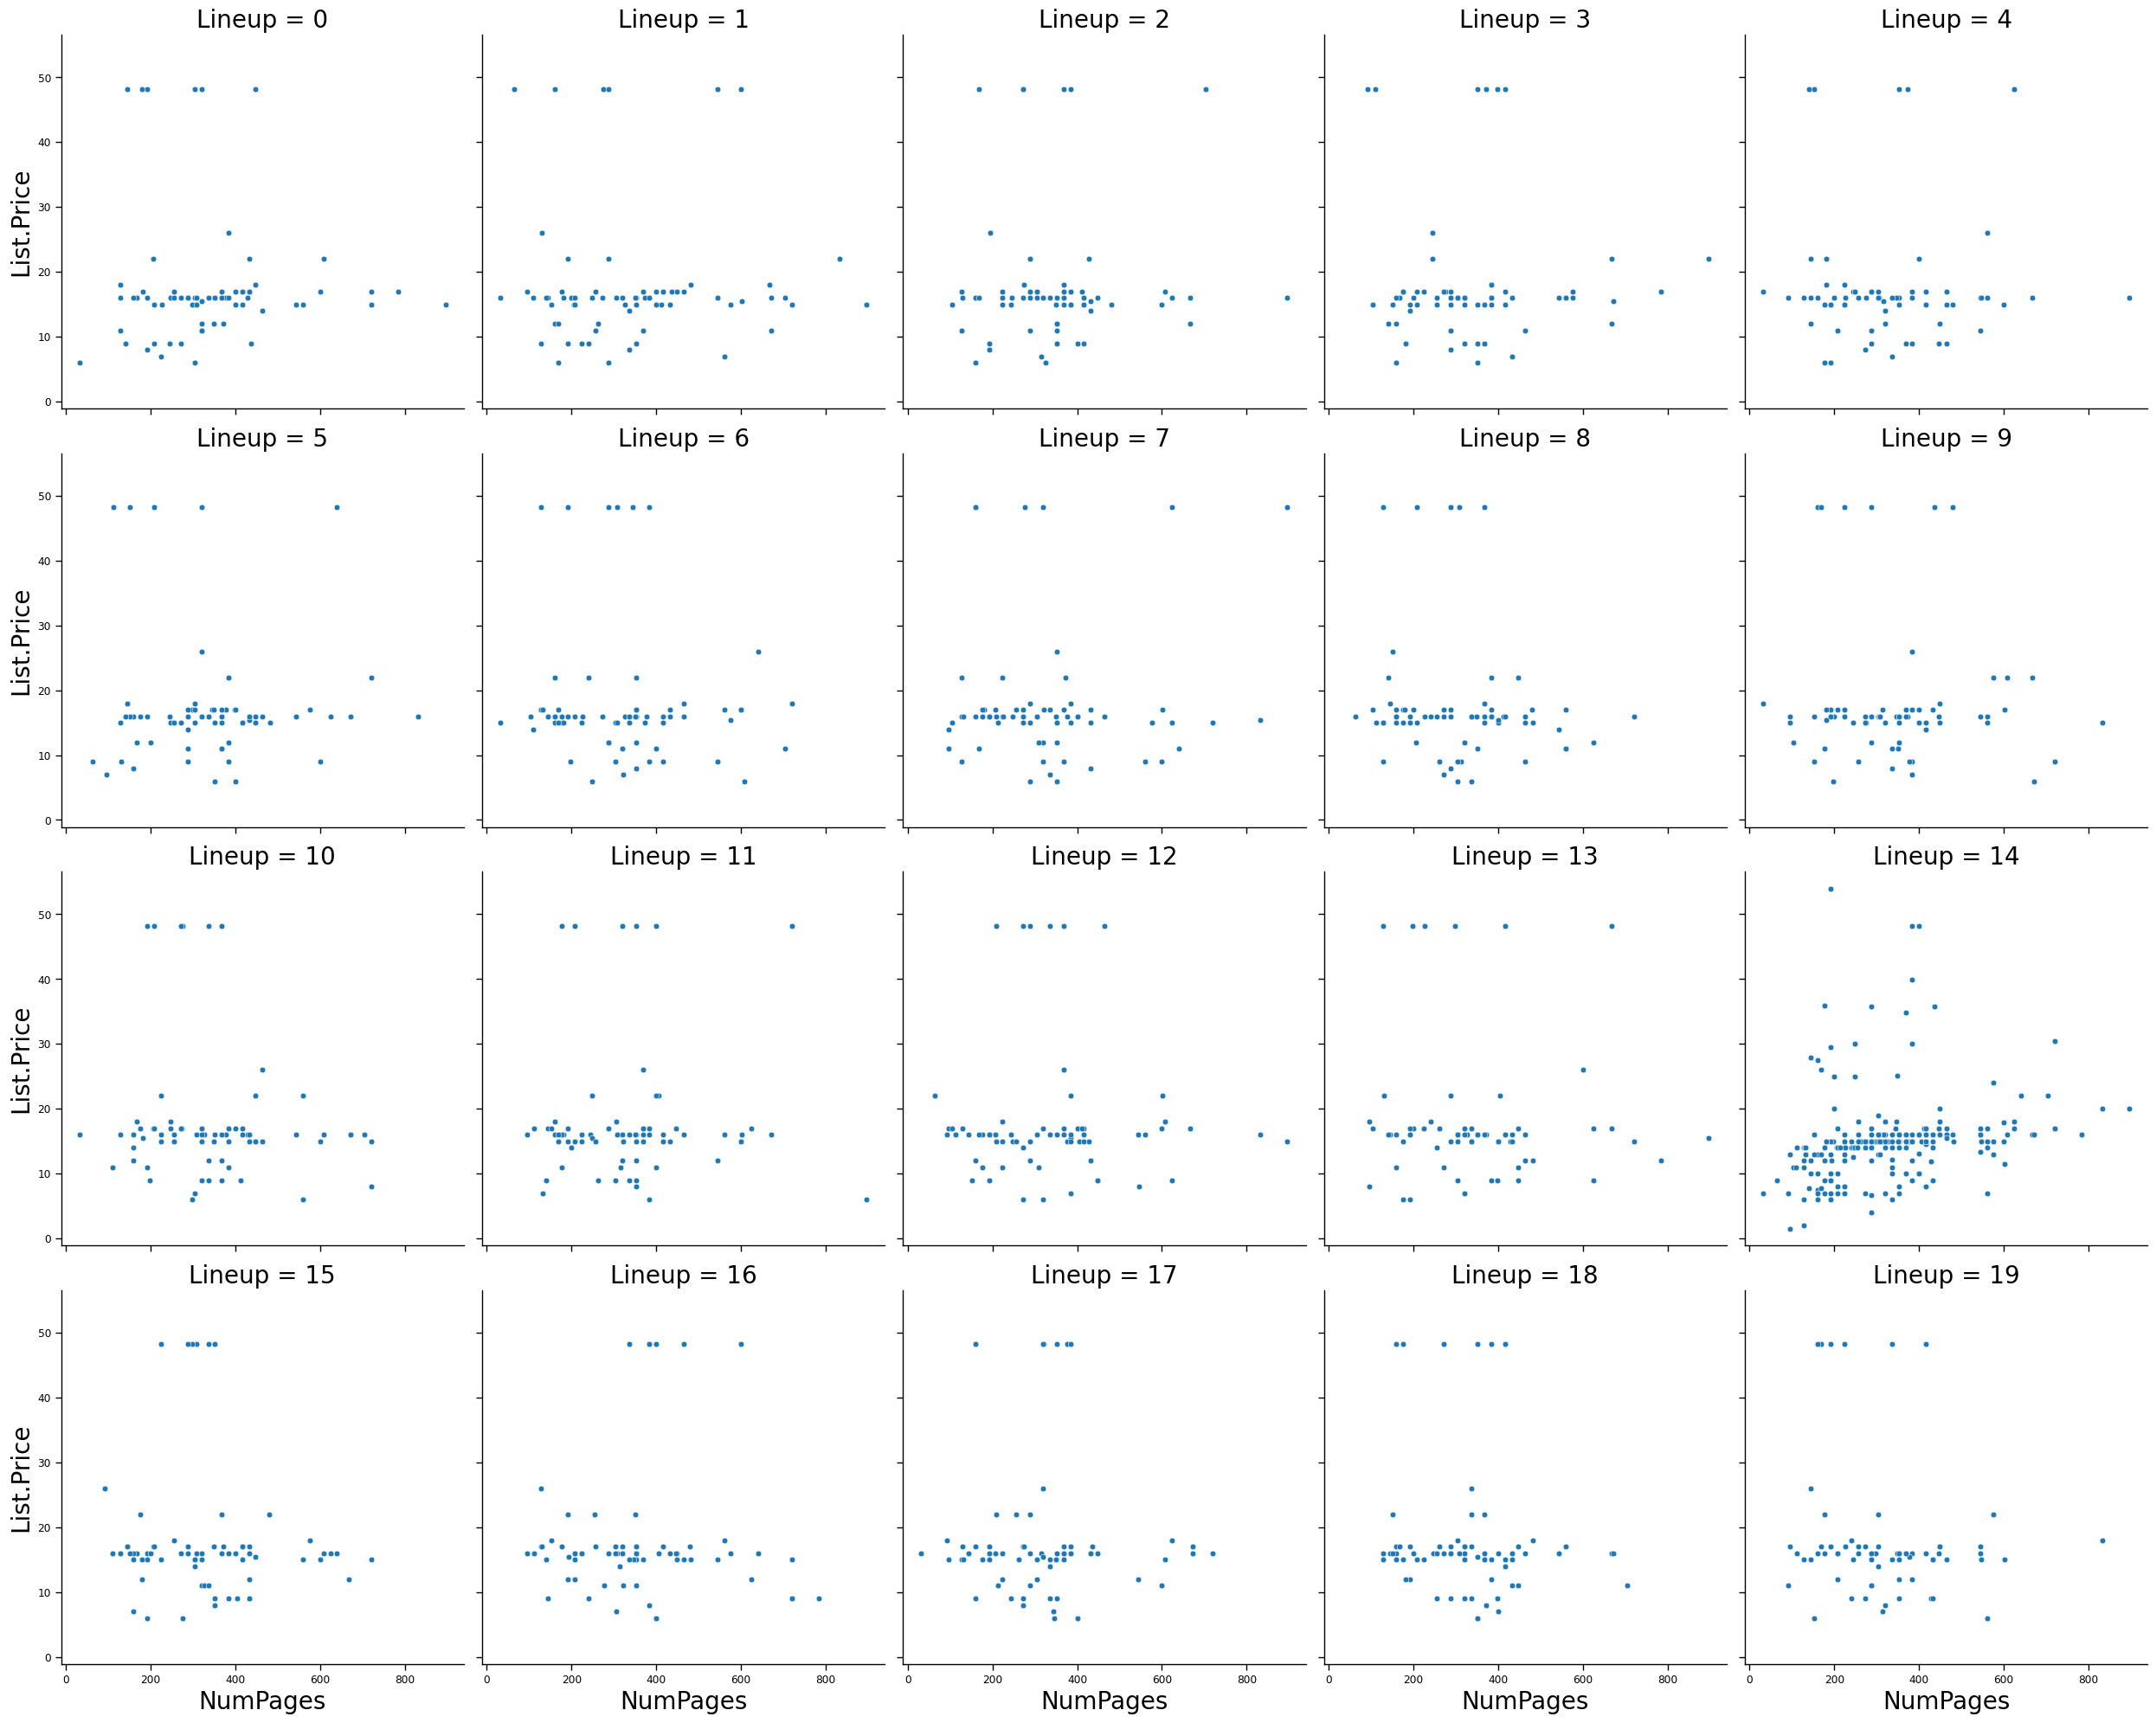

In [70]:
# np.random.seed(123)

def create_lineup(the_data): 
    
    real_plot_num = np.random.permutation(range(20))[0]
    lineup_data = pd.DataFrame()
    
    for i in range(20):
        
        if i == real_plot_num:
            curr_data = the_data.copy()
        
        else:
            curr_data = pd.DataFrame(the_data.iloc[:, 1], the_data.iloc[:, 0]).reset_index()
            curr_data[curr_data.columns[1]] = np.random.permutation(curr_data[curr_data.columns[1]])
        
        curr_data.loc[:, "Lineup"] = i
        lineup_data = pd.concat([lineup_data, curr_data])
        
    lineup_data = lineup_data.reset_index()

    sns.set_context("paper", rc={"axes.labelsize":20})   
    sns.relplot(lineup_data, x = lineup_data.columns[1], y = lineup_data.columns[2], col = "Lineup", col_wrap=5); 

    return real_plot_num


the_answer = create_lineup(amazon_smaller)



In [57]:
# display the answer

# the_answer


## 3. Two-sided hypothesis test

Sometime in hypothesis testing we don't know the direction of an effect, we only know that the null hypothesis is incorrect. 

In these circumstances, we write our alternative hypothesis such that we state that the parameter value is not equal to the value specified by the null hypothesis.

For the testing whether there is a correlation between the number of pages in a book and price we can write our hypotheses as:

$H_0: \rho = 0$   

i.e., the null hypothesis is the same as before.

$H_A: \rho \ne 0$

We now use not equal to ($\ne$) in our alternative hypothesis.  

To calculate the p-value, we need to look at the values more extreme than the observed statistic in in both tails. 

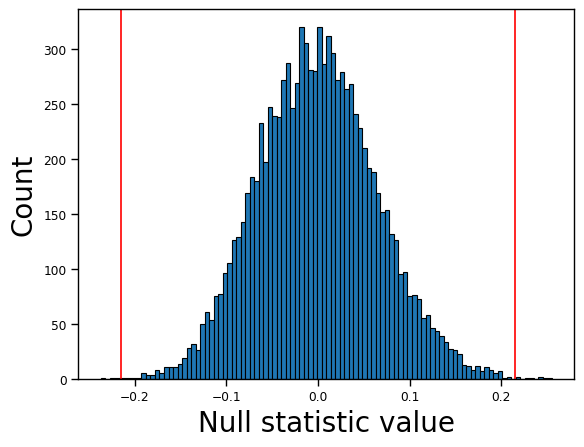

In [58]:
# visualize the null distribution 

plt.hist(null_dist, edgecolor = "black", bins = 100);


# put lines showing values more extreme than the observed statistic

plt.axvline(obs_stat, color = "red");
plt.axvline(-1 * obs_stat, color = "red");

plt.xlabel("Null statistic value");
plt.ylabel("Count");


When calculating the p-value, we need to get the proportion of statistics in the null distribution that are more extreme than the observed statistic from both tails.

In [59]:
p_value_right = np.mean(np.array(null_dist) >= obs_stat)
p_value_left = np.mean(np.array(null_dist) <= -1 * obs_stat)

p_value = p_value_right + p_value_left

p_value 


0.0012000000000000001

## 4. Using hypothesis tests to generate confidence intervals

There are several methods we that can be used to calculate confidence intervals, including using a computational method called the "bootstrap" and using "parametric methods" that involve using probability distributions. If you take a traditional introductory statistics class you will learn some of these methods.

Below we use a less conventional method to calculate confidence intervals by looking at all parameters values that a hypothesis test fails to reject (at the p-value < 0.05 level). As you will see, the method gives similar results to other methods, although it requires a bit more computation time.

As an example, let's create a confidence interval for the population proportion of movies $\pi$ that pass the Bechdel test. As is the case for all confidence intervals, this confidence interval gives a range of plausible values that likely contains the true population proportion $\pi$.


In [60]:
# To start, let's use a function that generates a statistic p-hat that is consistent with a particular population parameter value pi

def generate_proportion(n, prob_heads):
    
    random_sample = np.random.rand(n) <= prob_heads
    return np.mean(random_sample)

generate_proportion(1794, .5)



0.49331103678929766

In [61]:
# The function below calculates a p-value for the Bechdel data based on a particular pi value that is specified in a null hypothesis.
# (i.e., it is a function that encapsulates the hypothesis test you ran in class 20).


def get_Bechdel_pvalue(null_hypothesis_pi, plot_null_dist = False):
    
    
    # The observed p-hat value
    prop_passed = 803/1794
    
    
    # Generate the null distribution 
    null_dist = []
    
    for i in range(10000):    
        null_dist.append(generate_proportion(1794, null_hypothesis_pi))
    
    
    # Calculate a "two-tailed" p-value which is the proportion of statistcs more extreme than the observed statistic

    statistic_deviation = np.abs(null_hypothesis_pi - prop_passed)  # distance between p-hat and pi_0
    
    pval_left = np.mean(np.array(null_dist) <= null_hypothesis_pi - statistic_deviation)
    pval_right = np.mean(np.array(null_dist) >= null_hypothesis_pi + statistic_deviation)    
    
    p_value = pval_left + pval_right


    
    # plot the null distribution and lines indicating values more extreme than the observed statistic 
    if plot_null_dist:
        
        plt.hist(null_dist, edgecolor = "black", bins = 30);
        plt.axvline(null_hypothesis_pi - statistic_deviation, color = "red");
        plt.axvline(null_hypothesis_pi + statistic_deviation, color = "red");
        plt.axvline(null_hypothesis_pi, color = "yellow");

        
        plt.title("Pi-null is: " + str(null_hypothesis_pi) + "      "  +
                  "p-value is: " + str(round(p_value, 5)))
      
    # return the p-value
    return p_value
    


0.8553999999999999

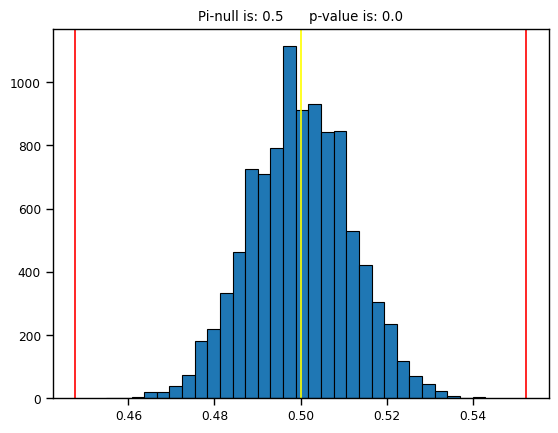

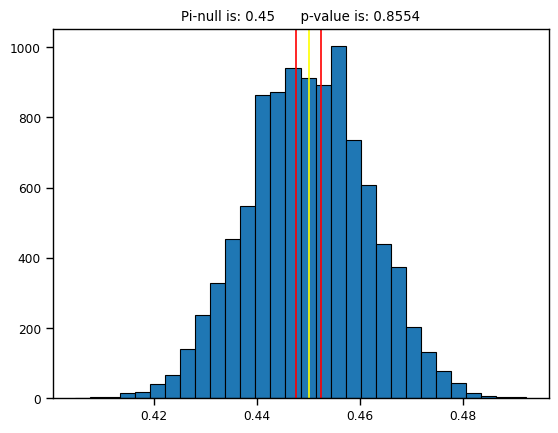

In [62]:
# test the function with the value H0: pi = .5  (as we did in class 20)
get_Bechdel_pvalue(.5, True)


# test the function with the value H0: pi = .45
plt.figure()
get_Bechdel_pvalue(.45, True)

In [63]:
# create a range range of H0: pi = x  values

possible_null_pis = np.round(np.arange(.4, .5, .005), 5)

possible_null_pis    


array([0.4  , 0.405, 0.41 , 0.415, 0.42 , 0.425, 0.43 , 0.435, 0.44 ,
       0.445, 0.45 , 0.455, 0.46 , 0.465, 0.47 , 0.475, 0.48 , 0.485,
       0.49 , 0.495])

In [64]:
%%time


# get the p-value for a range of H0: pi = x  values


pvalues = []

for null_pi in possible_null_pis:
    
    curr_pvalue = get_Bechdel_pvalue(null_pi)
    
    pvalues.append(curr_pvalue)



CPU times: user 5.76 s, sys: 49.1 ms, total: 5.81 s
Wall time: 6.15 s


In [65]:
# view the p-values 
# convention calls a p-value < 0.05 is "statistically significant" indicating a pi imcompatible with the null hypothesis
# our confidence interval is all pi values that are not statistically significant (i.e., pi values that are consistent with particular H0)

pvalue_df = pd.DataFrame({"pi": possible_null_pis, 
                          "p-values": pvalues,
                          "non-significant": np.array(pvalues) > .05})

pvalue_df


,pi,p-values,non-significant
0,0.400,0.0000,False
1,0.405,0.0004,False
2,0.410,0.0014,False
3,0.415,0.0061,False
4,0.420,0.0189,False
5,0.425,0.0550,True
6,0.430,0.1320,True
7,0.435,0.2839,True
8,0.440,0.5136,True
9,0.445,0.8324,True


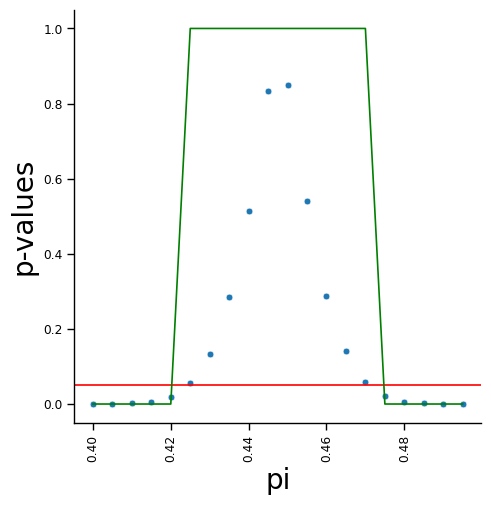

In [66]:
# plot p-values as as function of H0 pi's

sns.relplot(pvalue_df, x = 'pi', y = 'p-values');
plt.xticks(rotation=90);
plt.axhline(.05, color = "red");

plt.plot(pvalue_df['pi'], pvalue_df['non-significant'], color = "green");


In [67]:
# Get all plausible Pi values
fail_to_reject_pis = possible_null_pis[np.array(pvalues) >= .05]

fail_to_reject_pis

array([0.425, 0.43 , 0.435, 0.44 , 0.445, 0.45 , 0.455, 0.46 , 0.465,
       0.47 ])

In [68]:
# get the CI as the max and min plausible pi values 

(min(fail_to_reject_pis), max(fail_to_reject_pis))


(0.425, 0.47)

In [69]:
# using the statsmodels package to compute a confidence interval for a proportion

import statsmodels.api as sm

ci_low, ci_upp = sm.stats.proportion_confint(803, 1794, alpha=0.05, method='normal')
(round(ci_low, 3), round(ci_upp, 3))


(0.425, 0.471)